<a href="https://colab.research.google.com/github/dbenham/nairr-sandbox-app-2/blob/main/index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Making Biomedical Data FAIR on the NAIRR (EAGER)**

---



## Overall goal: making biomedical data available for AI



**A lot of biomedical data is "dark data"**
- "hidden" in research centers and health systems
- not FAIR: **F**indable, **A**ccessible, **I**nteroperable, **R**eusable
- AI researchers cannot create AI systems to find cures for diseases if they cannot access the data!

**This project**
- takes **genomics data from real patients**
- uses it to train synthetic data generators on the NAIRR (AWS, TACC Vista, TACC Frontera)
- generates **artificial genomics data** and publishes it on the NAIRR

**Contributions to NAIRR**
- synthetic biomedical data that preserves patient privacy and
can be used to train AI models for disease diagnosis and treatment
- cryptographic protocols to support future NAIRR Secure




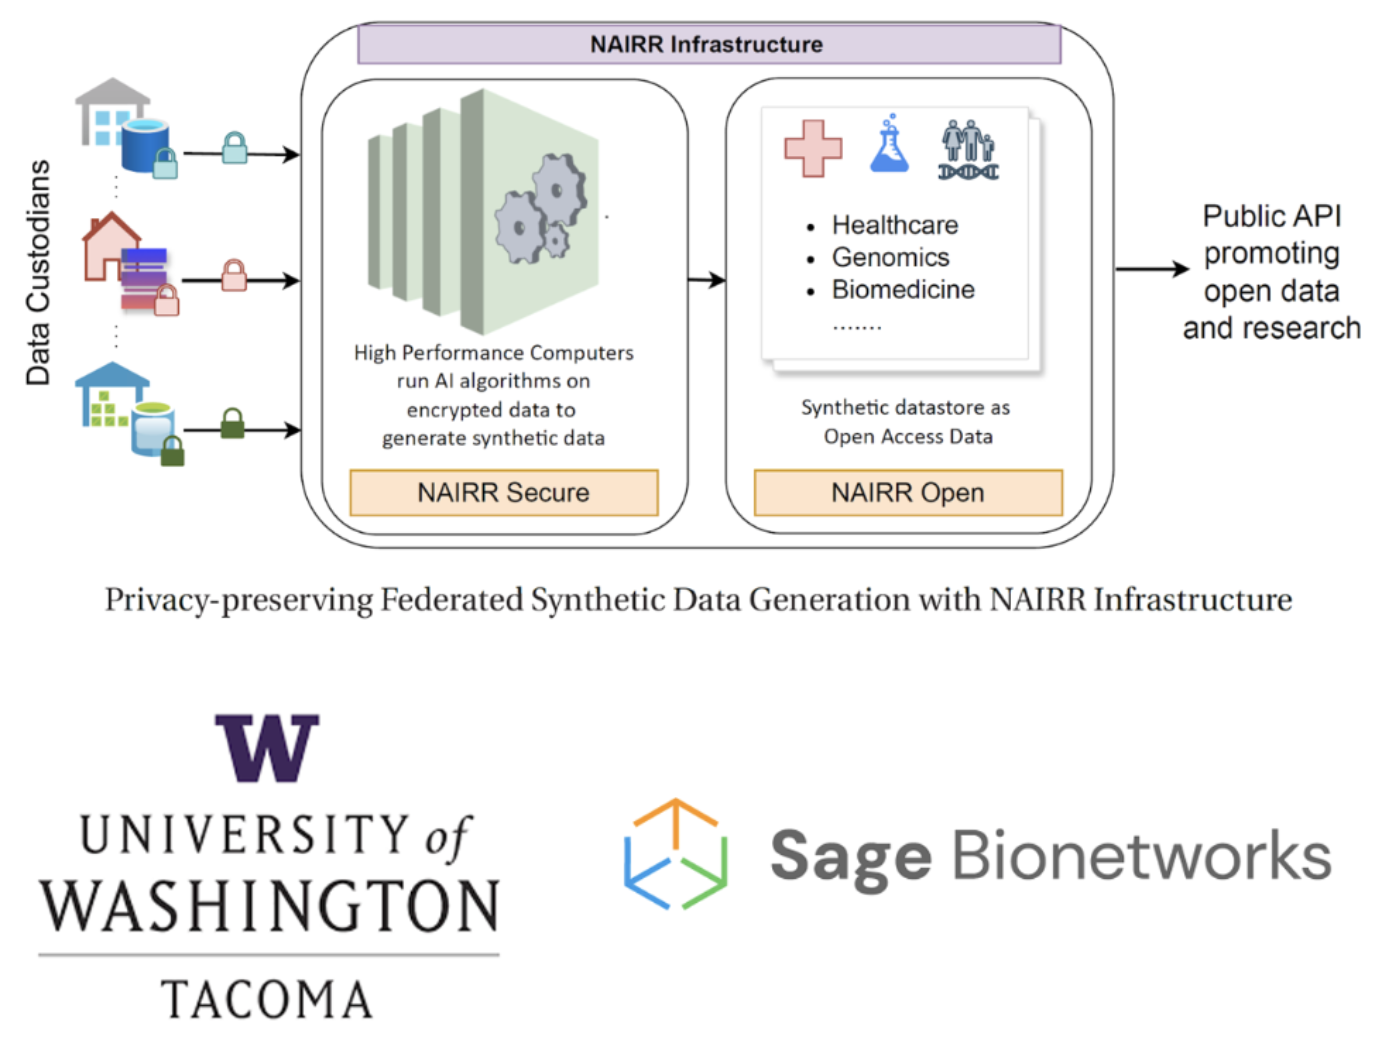





# Demonstration of Unlocking Rare Disease Data for NF1 Research

### **Generating synthetic replica of real NF1 dataset while preserving privacy**

## Application

**Neurofibromatosis Type 1 (NF1)** is a rare genetic disorder which occurs in 1 in 3,000 to 4,000 people worldwide. Research and discoveries, especially AI-driven discoveries, are limited for NF1 due to the data scarcity and "dark data" challenges. In this demo, we will develop synthetic genomic data for NF1 that can address the above challenges.

[Project page](https://www.synapse.org/Synapse:syn64919277/wiki/631426)


**Broad Research Questions:**
1. Which synthetic data generators (SDGs) work best for NF1?
2. Being a rare disease, the data required to train SDGs should be collected from multiple data custodians (such as hospitals and labs). But the sensitive genomic data is highly regulated and  raises serious privacy concerns for patients in the free-flowing data pipelines. How can one train SDGs on this collective data while preserving privacy?

**Objectives:**
1. Study strengths and limitations of existing SDGs to generate genomic (germline) synthetic data for NF1. Develop novel SDGs based on the study.
2. Use cryptographic techniques combined with differential privacy to train and generate synthetic genomic data for NF1.

For demonstration purposes, we will work with a less sensitive type of genomic data — **RNA-Seq data for NF1** — and focus on Objective 1.

*RNA-Seq data captures the expression levels of genes across samples.* For NF1, this means we can measure how strongly each gene is expressed in different tumor types (e.g., plexiform neurofibromas, cutaneous neurofibromas, malignant peripheral nerve sheath tumors) and in matched cell line or xenograft models. RNA-Seq data can be considered as tabular data, where columns = genes or transcripts, rows = samples, cell values = expression levels (raw counts, TPM, or normalized values).

## Simplified AI workflow on NAIRR

### Step 1: Download sensitive data from external data sources on TACC Vista

We started our project by taking data from [Synapse platform](https://www.synapse.org/). Below we show scripts to download *authorized* data by an *authorized user*

Once we have the data, we preprocess it, train and tune the synthesizers, and evaluate the results. This pipeline is executed using k-fold cross-validation, across multiple random seeds and repeated rounds. The aggregated metrics are then analyzed to assess the fidelity and utility of the synthetic data.

For demonstration purposes, we have unrolled the looped code that we run on TACC Vista and Frontera below, simplified the code for demo and show single run of evaluation.

In [ ]:
# This requires installing synapse
# synapse get -r <obj_id> --downloadLocation ~/test/

In [ ]:
path = "work/data/biomed-sandbox/"

In [ ]:
import glob
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder

def get_combined_labelled_data(path):
    # get all RNSSeq data
    tsv_files = glob.glob(os.path.join(path, "*.tsv"))
    dataframes, stats = {}, {}

    # Filter genes and transform data
    filter_list = path + "hm_dnarepair.csv"
    filtered_features = pd.read_csv(filter_list)[['Symbol']].values.flatten()

    for i,file in enumerate(tsv_files):
        original_df = pd.read_csv(file, sep="\t").drop(columns=['gene_id'])
        transposed_df = original_df.transpose()
        new_headers = transposed_df.iloc[0]
        transposed_df = transposed_df.iloc[1:]
        new_cols = list(new_headers)
        transposed_df.columns = new_cols
        # for f in filtered_features:
        #     if f not in new_cols:
        #         print("Missing gene name in:",i, f)
        valid_features = [f for f in filtered_features if f in new_cols]
        # if len(valid_features) < len(L1000_features):
        #     print(f"Warning: File {os.path.basename(file)} is missing {len(filtered_features) - len(valid_features)} filtered features")
        transposed_df = transposed_df[valid_features]
        dataframes[i] = transposed_df

    # Combine all data
    all_data = pd.concat(dataframes.values(), axis=0, keys=range(len(dataframes))).dropna(axis=1)
    all_data = all_data.apply(pd.to_numeric, errors='coerce')


    # Process labels
    labels_df = pd.read_excel(path + "labels.xlsx")
    label_column = 'tumorType'
    rowid = 'specimenID'
    #labels['ID'] = labels[rowid].apply(lambda x: '-'.join(x.split('.')))
    # t = all_data.index.to_series()
    label_encoder = LabelEncoder()
    labels_df[label_column] = label_encoder.fit_transform(labels_df[label_column])
    label_map = label_encoder.classes_
    label_dict = {}
    for ind, ll in enumerate(label_map):
        label_dict[ll] = ind

    def getLabel(x):
        index_key = '-'.join(x[1].split('.')[:4])
        label_row = labels_df[labels_df[rowid] == index_key]
        label = label_row[label_column].values[0] if not label_row.empty else -1
        return label

    all_data['label'] = all_data.index.to_series().apply(lambda x: getLabel(x))
    all_data['label'] = all_data['label'].apply(lambda x: 1 if x == 3 else 0)
    all_data.to_csv(path + "RNASeq_NF1.csv",index=False)

For simplicity we have already downloaded the combined and labelled the RNA-Seq data.

In [ ]:
# The RNASeq data is uploaded in the local data folder as a CSV file
import pandas as pd

df_rnaseq = pd.read_csv(path + "RNASeq_NF1_train.csv")
print(df_rnaseq.shape)

FileNotFoundError: [Errno 2] No such file or directory: 'sample_data/data_demo_NAIRR/RNASeq_NF1_train.csv'

In [ ]:
# If you are authorized, you can look at the data to perform EDA. We do not show the original data due to privacy regulations.
## df_rnaseq.head()

### Step 2: Train AI models on TACC Vista to generate synthetic NF1 data

We demonstrate the study of a marginal-based SDG  called **Private-PGM** (McKenna et al.) for NF1. Marginal-based SDGs, such as Private-PGM, are among the state-of-the-art approaches for generating differentially private tabular synthetic data. These models aim to preserve important statistical properties such as low-dimensional marginals while providing formal privacy guarantees.

Firstly, the datasets need to be preprocessed to suit the synthetizer. For Private-PGM, we need to discretize the data.

In [ ]:
def discretize_data(df):
    assert alpha < 0.5, "The alpha (quantile) should be smaller than 0.5"

    alphas = [alpha, 0.5, 1 - alpha]  # Quantiles for discretization
    #alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,0.9]
    bin_number = len(alphas) + 1
    df_copy = df.copy()
    data_quantile = np.quantile(df, alphas, axis=0)

    statistic_dict = {}
    mean_dict = {}
    quantile_dict = {}
    for col in df.columns:
        if col != 'label':
            col_quantiles = data_quantile[:, df.columns.get_loc(col)]
            discrete_col = np.digitize(df[col], col_quantiles)
            df[col] = discrete_col
            quantile_dict[col] = col_quantiles

            statistic_dict[col] = []
            mean_dict[col] = []
            for bin_idx in range(bin_number):
                bin_arr = df_copy[col][discrete_col == bin_idx]
                statistic_dict[col].append(len(bin_arr))
                mean_dict[col].append(np.mean(bin_arr) if len(bin_arr) > 0 else np.nan)

    return df, statistic_dict, mean_dict, quantile_dict

def un_discretize_data(df, mean_dict):
    for k,v in mean_dict.items():
      df[k] = df[k].apply(lambda x: v[x])
    return df

In [ ]:
def pre_process_data(df, is_train):
    # We discreteize the data in to 4 quartiles for Private-PGM
    if is_train:
       df, statistic_dict, mean_dict, quantile_dict = discretize_data(df)
    return df, mean_dict

#df_train, mean_dict = pre_process_data(df_train, 1)

In [ ]:
df_train_disc = pd.read_csv(path + "df_train_processed.csv")

We train the generator only on the training data. The looped code includes hyperparameter tuning. Below we train data for one of the better performing set of parameters.

In [ ]:
'''
from model import Private_PGM

def train_private_pgm(df_train):
  model = Private_PGM(
    "label", True, 1, 1e-5)
  config = {}
  for col in df_train.columns:
    config[str(col)] = df_train[col].nunique()
  model.train(df_train, config, num_iters=25)
  df_synth_train = model.generate(num_rows=df_train.shape[0])
  df_synth_train = pd.DataFrame(df_synth_train)
  df_synth_train.columns = df_train.columns
  return df_synth_train
'''

'\nfrom model import Private_PGM\n\ndef train_private_pgm(df_train):\n  model = Private_PGM(\n    "label", True, 1, 1e-5)\n  config = {}\n  for col in df_train.columns:\n    config[str(col)] = df_train[col].nunique()\n  model.train(df_train, config, num_iters=25)\n  df_synth_train = model.generate(num_rows=df_train.shape[0])\n  df_synth_train = pd.DataFrame(df_synth_train)\n  df_synth_train.columns = df_train.columns\n  return df_synth_train\n'

To evalauate the synthesizer, the looped code will evalaute over multiple generated sample sets of the same size as training data. Below, we consider one generater sample set.

In [ ]:
# df_synth_train = train_private_pgm(df_train_disc)
# df_synth_train = un_discretize_data(df_synth_train, mean_dict)
df_synth_train = pd.read_csv(path + "df_synth_train.csv")


In [ ]:
# We do not show the synthetic data unless we have evaluated its privacy. Synthetic data is /<>
## df_synth_train.head()

### Step 3: Assessing suitability of generator for NF1 RNA-Seq data by evaluating the quality of generated data

We evaluate the quality of synthetic data on three different dimensions -- **utility, fidelity and privacy**.

- Utility refers to how suitable the generated synthetic data is for a downstream task when compared to real train data. We do this by training a machine learning classifier to predict the label (type of NF1).

- Fidelity refers to how closely the generated synthetic data resembles the statistical properties and distributions of the real train data. Though multiple statistics can be used. We use metrics from SDV to get a report on fidelity.

- Privacy refers to how well the synthetic data protects sensitive information in the real train data and prevents re-identification or inference attacks against individuals in the real train data. Our codebase intends to incoproarate computationally heavy membership inference attacks. For the demo purposes and consider the level of sensitivity of RNA-Seq data, we use DCR (Distance to Closest Record) as our privacy metric; DCR measures how far each synthetic data point is from the nearest real record in the train dataset.

#### Step 3.1: Utility Evaluation

We measure AUC-ROC and F1-score for the classification taks. Higher the value better the utility of synthetic data.

In [ ]:
from sklearn.metrics import roc_auc_score, f1_score
import lightgbm as lgb

def train_lgbm(df_train, df_test):
    # Separate features and target
    X_train = df_train.drop(columns=['label'])
    y_train = df_train['label']

    X_test = df_test.drop(columns=['label'])
    y_test = df_test['label']

    # Define LightGBM parameters
    lgb_params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbose': -1
    }

    # Initialize and train model
    lgb_model = lgb.LGBMClassifier(**lgb_params, random_state=42)
    lgb_model.fit(X_train, y_train)

    # Predict probabilities and class labels
    y_pred_prob = lgb_model.predict_proba(X_test)[:, 1]
    y_pred = lgb_model.predict(X_test)

    # Compute AUC and F1 score
    auc = roc_auc_score(y_test, y_pred_prob)
    f1 = f1_score(y_test, y_pred)

    return auc, f1


In [ ]:
from sklearn.model_selection import KFold
import numpy as np

def cross_validate_lgbm(df_train_real, df_train_synth, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    auc_real_scores = []
    f1_real_scores = []
    auc_synth_scores = []
    f1_synth_scores = []

    for fold, (train_index, val_index) in enumerate(kf.split(df_train_real)):
        print(f"Fold {fold+1}/{n_splits}")
        df_train_fold_real = df_train_real.iloc[train_index]
        df_val_fold_real = df_train_real.iloc[val_index]
        df_train_fold_synth = df_train_synth.iloc[train_index]
        df_val_fold_synth = df_train_synth.iloc[val_index]


        auc_real, f1_real = train_lgbm(df_train_fold_real, df_val_fold_real)
        auc_synth, f1_synth = train_lgbm(df_train_fold_synth, df_val_fold_synth)

        auc_real_scores.append(auc_real)
        f1_real_scores.append(f1_real)
        auc_synth_scores.append(auc_synth)
        f1_synth_scores.append(f1_synth)

    avg_auc_real = np.mean(auc_real_scores)
    avg_f1_real = np.mean(f1_real_scores)
    avg_auc_synth = np.mean(auc_synth_scores)
    avg_f1_synth = np.mean(f1_synth_scores)


    return avg_auc_real, avg_f1_real, avg_auc_synth, avg_f1_synth
'''
avg_auc_real, avg_f1_real, avg_auc_synth, avg_f1_synth = cross_validate_lgbm(df_rnaseq, df_synth_train)

print("\nAverage Classification Results across 5-fold cross-validation:")
print(f"Real data: Average AUC = {avg_auc_real:.4f}, Average F1 = {avg_f1_real:.4f}")
print(f"Synthetic data: Average AUC = {avg_auc_synth:.4f}, Average F1 = {avg_f1_synth:.4f}")
'''

'\navg_auc_real, avg_f1_real, avg_auc_synth, avg_f1_synth = cross_validate_lgbm(df_rnaseq, df_synth_train)\n\nprint("\nAverage Classification Results across 5-fold cross-validation:")\nprint(f"Real data: Average AUC = {avg_auc_real:.4f}, Average F1 = {avg_f1_real:.4f}")\nprint(f"Synthetic data: Average AUC = {avg_auc_synth:.4f}, Average F1 = {avg_f1_synth:.4f}")\n'

#### Step 3.2: Fidelity Evaluation

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

def get_fidelity_report(df_train, df_synth_train):
    print("="*80)
    print("FIDELITY EVALUATION: REAL vs SYNTHETIC DATA")
    print("="*80)

    # Basic dataset info
    print(f"\nDATASET OVERVIEW:")
    print(f"Real data shape: {df_train.shape}")
    print(f"Synthetic data shape: {df_synth_train.shape}")

    # Separate features and target (assuming last column is target)
    features_real = df_train.iloc[:, :-1]
    target_real = df_train.iloc[:, -1]
    features_synth = df_synth_train.iloc[:, :-1]
    target_synth = df_synth_train.iloc[:, -1]

    # 1. BASIC STATISTICAL COMPARISON
    print(f"\n1. BASIC STATISTICS COMPARISON")
    print("-" * 50)

    stats_comparison = pd.DataFrame({
        'Real_Mean': features_real.mean(),
        'Synth_Mean': features_synth.mean(),
        'Real_Std': features_real.std(),
        'Synth_Std': features_synth.std(),
        'Real_Min': features_real.min(),
        'Synth_Min': features_synth.min(),
        'Real_Max': features_real.max(),
        'Synth_Max': features_synth.max()
    })

    # Calculate mean absolute differences
    mean_diff = np.abs(stats_comparison['Real_Mean'] - stats_comparison['Synth_Mean']).mean()
    std_diff = np.abs(stats_comparison['Real_Std'] - stats_comparison['Synth_Std']).mean()

    print(f"Average absolute difference in means: {mean_diff:.6f}")
    print(f"Average absolute difference in std devs: {std_diff:.6f}")

    # 2. CORRELATION ANALYSIS
    print(f"\n2. CORRELATION STRUCTURE COMPARISON")
    print("-" * 50)

    corr_real = features_real.corr()
    corr_synth = features_synth.corr()

    # Frobenius norm difference between correlation matrices
    corr_diff = np.linalg.norm(corr_real.values - corr_synth.values, 'fro')
    print(f"Correlation matrix Frobenius norm difference: {corr_diff:.6f}")

    # Mean absolute correlation difference
    corr_mae = np.mean(np.abs(corr_real.values - corr_synth.values))
    print(f"Mean absolute correlation difference: {corr_mae:.6f}")

    # 3. DISTRIBUTION COMPARISON (KS TEST)
    print(f"\n3. DISTRIBUTION COMPARISON (Kolmogorov-Smirnov Test)")
    print("-" * 50)

    ks_statistics = []
    ks_p_values = []

    for col in features_real.columns:
        ks_stat, p_value = stats.ks_2samp(features_real[col], features_synth[col])
        ks_statistics.append(ks_stat)
        ks_p_values.append(p_value)

    avg_ks_stat = np.mean(ks_statistics)
    significant_features = sum(1 for p in ks_p_values if p < 0.05)

    print(f"Average KS statistic: {avg_ks_stat:.6f}")
    print(f"Features with significantly different distributions (p<0.05): {significant_features}/{len(features_real.columns)}")
    print(f"Percentage of features with similar distributions: {((len(features_real.columns) - significant_features) / len(features_real.columns)) * 100:.1f}%")

    # 4. TARGET DISTRIBUTION COMPARISON
    print(f"\n4. TARGET VARIABLE COMPARISON")
    print("-" * 50)

    target_real_counts = target_real.value_counts().sort_index()
    target_synth_counts = target_synth.value_counts().sort_index()

    print("Target distribution comparison:")
    target_comparison = pd.DataFrame({
        'Real_Count': target_real_counts,
        'Synth_Count': target_synth_counts,
        'Real_Prop': target_real_counts / len(target_real),
        'Synth_Prop': target_synth_counts / len(target_synth)
    })
    print(target_comparison)

    # Chi-square test for target distribution
    chi2_stat, chi2_p = stats.chisquare(target_synth_counts, target_real_counts)
    print(f"\nChi-square test for target distribution:")
    print(f"Chi-square statistic: {chi2_stat:.6f}")
    print(f"P-value: {chi2_p:.6f}")

    # 5. FEATURE IMPORTANCE SIMILARITY (using variance as proxy)
    print(f"\n5. FEATURE IMPORTANCE SIMILARITY")
    print("-" * 50)

    var_real = features_real.var().sort_values(ascending=False)
    var_synth = features_synth.var().sort_values(ascending=False)

    # Spearman correlation of feature variances (as proxy for importance)
    importance_corr, importance_p = stats.spearmanr(var_real.values, var_synth.values)
    print(f"Feature importance correlation (Spearman): {importance_corr:.6f}")
    print(f"P-value: {importance_p:.6f}")

    # 6. DIMENSIONALITY REDUCTION COMPARISON
    print(f"\n6. DIMENSIONALITY REDUCTION COMPARISON")
    print("-" * 50)

    # Standardize features for PCA
    scaler = StandardScaler()
    features_real_scaled = scaler.fit_transform(features_real)
    features_synth_scaled = scaler.transform(features_synth)

    # PCA comparison
    pca = PCA(n_components=min(10, features_real.shape[1]))
    pca_real = pca.fit_transform(features_real_scaled)
    pca_synth = pca.transform(features_synth_scaled)

    # Compare explained variance ratios
    pca_real_var = pca.explained_variance_ratio_

    # Fit PCA separately on synthetic data to compare explained variance
    pca_synth_fit = PCA(n_components=min(10, features_real.shape[1]))
    pca_synth_fit.fit(features_synth_scaled)
    pca_synth_var = pca_synth_fit.explained_variance_ratio_

    pca_var_diff = np.mean(np.abs(pca_real_var - pca_synth_var))
    print(f"Average absolute difference in PCA explained variance ratios: {pca_var_diff:.6f}")

    # 7. PRIVACY ASSESSMENT (Distance to Closest Record)
    print(f"\n7. PRIVACY ASSESSMENT")
    print("-" * 50)

    # Sample a subset for computational efficiency
    sample_size = min(1000, len(features_real), len(features_synth))
    real_sample = features_real_scaled[:sample_size]
    synth_sample = features_synth_scaled[:sample_size]

    # Calculate minimum distances from synthetic to real data
    min_distances = []
    for i in range(len(synth_sample)):
        distances = np.linalg.norm(real_sample - synth_sample[i], axis=1)
        min_distances.append(np.min(distances))

    avg_min_distance = np.mean(min_distances)
    print(f"Average minimum distance from synthetic to real records: {avg_min_distance:.6f}")
    print(f"This suggests {'high' if avg_min_distance > 1.0 else 'moderate' if avg_min_distance > 0.5 else 'low'} privacy preservation")

    # 8. OVERALL FIDELITY SCORE
    print(f"\n8. OVERALL FIDELITY SUMMARY")
    print("=" * 50)

    # Normalize metrics to 0-1 scale (higher = better fidelity)
    mean_fidelity = 1 / (1 + mean_diff)  # Lower difference = higher fidelity
    corr_fidelity = 1 / (1 + corr_mae)   # Lower correlation difference = higher fidelity
    dist_fidelity = (len(features_real.columns) - significant_features) / len(features_real.columns)  # More similar distributions = higher fidelity
    importance_fidelity = max(0, importance_corr)  # Higher correlation = higher fidelity
    pca_fidelity = 1 / (1 + pca_var_diff)  # Lower PCA difference = higher fidelity

    overall_fidelity = np.mean([mean_fidelity, corr_fidelity, dist_fidelity, importance_fidelity, pca_fidelity])

    print(f"Mean Statistics Fidelity: {mean_fidelity:.3f}")
    print(f"Correlation Fidelity: {corr_fidelity:.3f}")
    print(f"Distribution Fidelity: {dist_fidelity:.3f}")
    print(f"Feature Importance Fidelity: {importance_fidelity:.3f}")
    print(f"PCA Fidelity: {pca_fidelity:.3f}")
    print(f"\nOVERALL FIDELITY SCORE: {overall_fidelity:.3f}")

    fidelity_rating = "Excellent" if overall_fidelity > 0.8 else "Good" if overall_fidelity > 0.6 else "Fair" if overall_fidelity > 0.4 else "Poor"
    print(f"Fidelity Rating: {fidelity_rating}")

    # 9. VISUALIZATIONS
    print(f"\n9. GENERATING VISUALIZATIONS...")
    print("-" * 50)

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Plot 1: Feature means comparison
    feature_means_real = features_real.mean()
    feature_means_synth = features_synth.mean()
    axes[0, 0].scatter(feature_means_real, feature_means_synth, alpha=0.6)
    axes[0, 0].plot([feature_means_real.min(), feature_means_real.max()],
                    [feature_means_real.min(), feature_means_real.max()], 'r--')
    axes[0, 0].set_xlabel('Real Data Feature Means')
    axes[0, 0].set_ylabel('Synthetic Data Feature Means')
    axes[0, 0].set_title('Feature Means Comparison')

    # Plot 2: Feature standard deviations comparison
    feature_stds_real = features_real.std()
    feature_stds_synth = features_synth.std()
    axes[0, 1].scatter(feature_stds_real, feature_stds_synth, alpha=0.6)
    axes[0, 1].plot([feature_stds_real.min(), feature_stds_real.max()],
                    [feature_stds_real.min(), feature_stds_real.max()], 'r--')
    axes[0, 1].set_xlabel('Real Data Feature Std Dev')
    axes[0, 1].set_ylabel('Synthetic Data Feature Std Dev')
    axes[0, 1].set_title('Feature Standard Deviations Comparison')

    # Plot 3: Correlation heatmap difference
    corr_diff_matrix = np.abs(corr_real.values - corr_synth.values)
    im = axes[0, 2].imshow(corr_diff_matrix, cmap='Reds', aspect='auto')
    axes[0, 2].set_title('Absolute Correlation Difference Heatmap')
    plt.colorbar(im, ax=axes[0, 2])

    # Plot 4: PCA comparison
    axes[1, 0].plot(range(1, len(pca_real_var)+1), pca_real_var, 'b-o', label='Real', markersize=4)
    axes[1, 0].plot(range(1, len(pca_synth_var)+1), pca_synth_var, 'r-s', label='Synthetic', markersize=4)
    axes[1, 0].set_xlabel('Principal Component')
    axes[1, 0].set_ylabel('Explained Variance Ratio')
    axes[1, 0].set_title('PCA Explained Variance Comparison')
    axes[1, 0].legend()

    # Plot 5: Target distribution comparison
    x_pos = np.arange(len(target_comparison))
    width = 0.35
    axes[1, 1].bar(x_pos - width/2, target_comparison['Real_Prop'], width, label='Real', alpha=0.7)
    axes[1, 1].bar(x_pos + width/2, target_comparison['Synth_Prop'], width, label='Synthetic', alpha=0.7)
    axes[1, 1].set_xlabel('Target Classes')
    axes[1, 1].set_ylabel('Proportion')
    axes[1, 1].set_title('Target Distribution Comparison')
    axes[1, 1].set_xticks(x_pos)
    axes[1, 1].set_xticklabels(target_comparison.index)
    axes[1, 1].legend()

    # Plot 6: KS test results
    axes[1, 2].hist(ks_statistics, bins=20, alpha=0.7, edgecolor='black')
    axes[1, 2].axvline(x=avg_ks_stat, color='red', linestyle='--', label=f'Average: {avg_ks_stat:.3f}')
    axes[1, 2].set_xlabel('KS Statistic')
    axes[1, 2].set_ylabel('Number of Features')
    axes[1, 2].set_title('Distribution of KS Statistics')
    axes[1, 2].legend()

    plt.tight_layout()
    plt.savefig('fidelity_evaluation_plots.png', dpi=300, bbox_inches='tight')
    plt.show()

    return {
        'overall_fidelity': overall_fidelity,
        'mean_difference': mean_diff,
        'correlation_difference': corr_mae,
        'ks_statistics': ks_statistics,
        'privacy_score': avg_min_distance,
        'target_chi2': chi2_stat,
        'importance_correlation': importance_corr
    }

# report = get_fidelity_report(df_train, df_synth_train)

#### Step 3.3: Privacy Evaluation

Higher DCR values indicate better privacy protection.

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, pairwise_distances
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def privacy_eval():
    def get_dcr(df_train, df_synth_train, distance_metric='euclidean', normalize=True):
        print("DCR Evaluation - Distance to Closest Record")
        print("-" * 50)
        print(f"Real data: {df_train.shape[0]} records")
        print(f"Synthetic data: {df_synth_train.shape[0]} records")

        # Use all columns except the last one (assumed to be target)
        features_real = df_train.iloc[:, :-1]
        features_synth = df_synth_train.iloc[:, :-1]

        # Normalize if requested
        if normalize:
            scaler = StandardScaler()
            features_real = scaler.fit_transform(features_real)
            features_synth = scaler.transform(features_synth)
        else:
            features_real = features_real.values
            features_synth = features_synth.values

        # Calculate distances from each synthetic record to all real records
        distances = pairwise_distances(features_synth, features_real, metric=distance_metric)

        # Find minimum distance for each synthetic record
        dcr_values = np.min(distances, axis=1)

        # Calculate statistics
        mean_dcr = np.mean(dcr_values)
        median_dcr = np.median(dcr_values)
        std_dcr = np.std(dcr_values)
        min_dcr = np.min(dcr_values)
        max_dcr = np.max(dcr_values)

        # Privacy risk thresholds (adjusted for normalization)
        if normalize:
            low_threshold = 0.1
            high_threshold = 0.5
        else:
            low_threshold = np.std(features_real) * 0.1
            high_threshold = np.std(features_real) * 0.5

        # Count records by risk level
        high_risk = np.sum(dcr_values < low_threshold)
        medium_risk = np.sum((dcr_values >= low_threshold) & (dcr_values < high_threshold))
        low_risk = np.sum(dcr_values >= high_threshold)

        # Privacy assessment
        if mean_dcr >= high_threshold:
            privacy_level = "HIGH"
        elif mean_dcr >= low_threshold:
            privacy_level = "MEDIUM"
        else:
            privacy_level = "LOW"

        # Print results
        print(f"\nResults:")
        print(f"Mean DCR: {mean_dcr:.4f}")
        print(f"Median DCR: {median_dcr:.4f}")
        print(f"Std DCR: {std_dcr:.4f}")
        print(f"Min DCR: {min_dcr:.4f}")
        print(f"Max DCR: {max_dcr:.4f}")

        print(f"\nPrivacy Assessment: {privacy_level}")
        print(f"High Risk Records: {high_risk} ({100*high_risk/len(dcr_values):.1f}%)")
        print(f"Medium Risk Records: {medium_risk} ({100*medium_risk/len(dcr_values):.1f}%)")
        print(f"Low Risk Records: {low_risk} ({100*low_risk/len(dcr_values):.1f}%)")

        return {
            'dcr_values': dcr_values,
            'mean_dcr': mean_dcr,
            'median_dcr': median_dcr,
            'std_dcr': std_dcr,
            'min_dcr': min_dcr,
            'max_dcr': max_dcr,
            'privacy_level': privacy_level,
            'high_risk_count': high_risk,
            'medium_risk_count': medium_risk,
            'low_risk_count': low_risk,
            'high_risk_pct': 100*high_risk/len(dcr_values),
            'medium_risk_pct': 100*medium_risk/len(dcr_values),
            'low_risk_pct': 100*low_risk/len(dcr_values)
        }

    def plot_dcr(dcr_results, save_plot=False):
        dcr_values = dcr_results['dcr_values']

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Plot 1: DCR Distribution
        axes[0].hist(dcr_values, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
        axes[0].axvline(dcr_results['mean_dcr'], color='red', linestyle='--',
                        label=f"Mean: {dcr_results['mean_dcr']:.3f}")
        axes[0].axvline(dcr_results['median_dcr'], color='orange', linestyle='--',
                        label=f"Median: {dcr_results['median_dcr']:.3f}")
        axes[0].set_xlabel('Distance to Closest Record')
        axes[0].set_ylabel('Frequency')
        axes[0].set_title('DCR Distribution')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        # Plot 2: Box Plot
        axes[1].boxplot(dcr_values, patch_artist=True,
                        boxprops=dict(facecolor='lightgreen', alpha=0.7))
        axes[1].set_ylabel('DCR Value')
        axes[1].set_title('DCR Box Plot')
        axes[1].grid(True, alpha=0.3)

        # Plot 3: Risk Assessment
        risk_labels = ['High Risk', 'Medium Risk', 'Low Risk']
        risk_counts = [dcr_results['high_risk_count'],
                       dcr_results['medium_risk_count'],
                       dcr_results['low_risk_count']]
        risk_colors = ['red', 'orange', 'green']

        bars = axes[2].bar(risk_labels, risk_counts, color=risk_colors, alpha=0.7)
        axes[2].set_ylabel('Number of Records')
        axes[2].set_title('Privacy Risk Assessment')
        axes[2].grid(True, alpha=0.3)

        # Add percentage labels on bars
        for bar, count, pct in zip(bars, risk_counts,
                                   [dcr_results['high_risk_pct'],
                                    dcr_results['medium_risk_pct'],
                                    dcr_results['low_risk_pct']]):
            axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                         f'{count}\n({pct:.1f}%)', ha='center', va='bottom')

        plt.tight_layout()

        if save_plot:
            plt.savefig('dcr_analysis.png', dpi=300, bbox_inches='tight')
            print("Plot saved as 'dcr_analysis.png'")

        plt.show()

    def compare_dcr_metrics(df_train, df_synth_train):
        print("Comparing DCR across different distance metrics:")
        print("=" * 60)

        metrics = ['euclidean', 'manhattan', 'cosine']
        results = {}

        for metric in metrics:
            print(f"\n{metric.upper()} Distance:")
            results[metric] = get_dcr(df_train, df_synth_train,
                                      distance_metric=metric, normalize=True)

        # Summary comparison
        print(f"\nSUMMARY COMPARISON:")
        print("-" * 40)
        print(f"{'Metric':<12} {'Mean DCR':<10} {'Privacy':<8} {'High Risk %'}")
        print("-" * 40)

        for metric in metrics:
            mean_dcr = results[metric]['mean_dcr']
            privacy = results[metric]['privacy_level']
            high_risk_pct = results[metric]['high_risk_pct']
            print(f"{metric:<12} {mean_dcr:<10.4f} {privacy:<8} {high_risk_pct:.1f}%")

        return results
    dcr_results = get_dcr(df_rnaseq, df_synth_train)
    plot_dcr(dcr_results)
    #all_results = compare_dcr_metrics(df_train, df_synth_train)



### Step 4: Publishing synthetic NF1 data for reuse (FAIR)

Upon assessing the privacy leakage tests, the generated synthetic data passes the evaluation. We are now publishing the RNA-Seq **NF1 synthetic dataset on NAIRR**. The data is **findable, accessible, interoperable, and reusable, enabling progress in NF1-based AI discoveries**.


DCR Evaluation - Distance to Closest Record
--------------------------------------------------
Real data: 44 records
Synthetic data: 44 records

Results:
Mean DCR: 12.7873
Median DCR: 12.7951
Std DCR: 0.4369
Min DCR: 11.5881
Max DCR: 13.8568

Privacy Assessment: HIGH
High Risk Records: 0 (0.0%)
Medium Risk Records: 0 (0.0%)
Low Risk Records: 44 (100.0%)


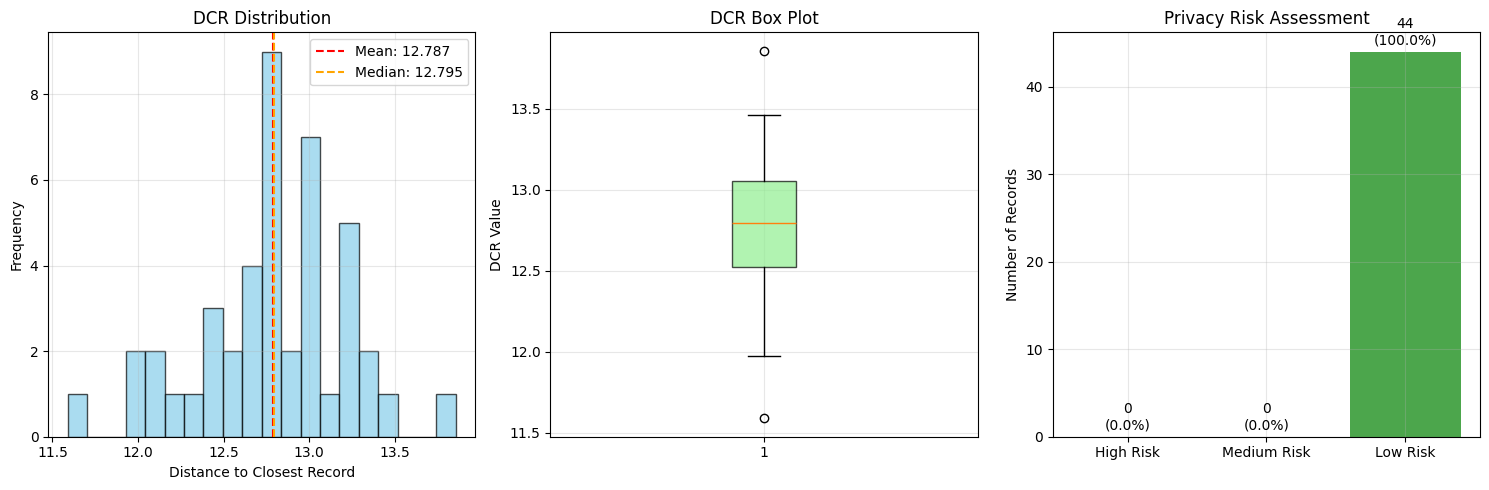

In [ ]:
privacy_eval()

## Demonstrating the use of synthetic dataset generated on NAIRR for NF1 disease diagnosis in patients

In [ ]:
# Loading synthetic dataset from NAIRR
df_synth_train = pd.read_csv(path + "df_synth_train.csv")
df_synth_train.head()

,AAAS,ADA,ADCY6,ADRM1,AK1,AK3,APRT,ARL6IP1,BCAM,BCAP31,...,UMPS,UPF3B,USP11,VPS28,VPS37B,VPS37D,XPC,ZNF707,ZWINT,label
0,477.818182,170.259182,2649.402091,304.597818,106.660091,780.999909,2183.545091,11013.170182,270.182182,5769.544727,...,1510.545273,114.545455,930.909091,4476.363909,1478.474455,90.083333,3039.935545,192.000000,20.818273,0
1,477.818182,278.091636,5007.579091,304.597818,278.580000,424.181727,606.545818,11013.170182,270.182182,478.090455,...,1011.363727,416.908818,10783.545636,425.182091,1478.474455,17.090909,3039.935545,92.909364,79.181909,0
2,197.182091,895.329091,14727.454818,304.597818,278.580000,424.181727,606.545818,549.934000,806.818182,1350.363273,...,1011.363727,58.545364,10783.545636,4476.363909,1478.474455,46.100000,1281.384545,324.363909,20.818273,0
3,197.182091,47.545182,1133.568182,939.709364,278.580000,780.999909,2183.545091,549.934000,270.182182,1350.363273,...,326.273000,114.545455,1913.000455,425.182091,2128.819636,17.090909,3039.935545,324.363909,79.181909,0
4,2038.090727,47.545182,1133.568182,2116.091091,1066.342364,780.999909,606.545818,11013.170182,270.182182,478.090455,...,188.454727,114.545455,930.909091,1082.454364,702.034182,280.909091,1281.384545,192.000000,950.636455,0


#### Use 1: Train AI model to label malignant and non-malignant NF1 for new patients

In [ ]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score

def train_lgbm_FAIR(df_train, df_test):
    lgb_params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbose': -1
    }

    # Separate features and labels
    X_train = df_train.drop('label', axis=1)
    y_train = df_train['label']
    X_test = df_test.drop('label', axis=1)
    y_test = df_test['label']

    lgb_model = lgb.LGBMClassifier(**lgb_params, random_state=42)
    lgb_model.fit(X_train, y_train)

    # Make predictions
    y_pred_proba = lgb_model.predict_proba(X_test)[:, 1]
    y_pred = lgb_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [ ]:
# Training a machine learning classifier to subtype NF1 on patients data without worrying about privacy of patients in training data
df_test = pd.read_csv(path + "RNASeq_NF1_test.csv")
accuracy = train_lgbm_FAIR(df_synth_train, df_test)
print(f"Accuracy of NF1 classification = {accuracy:.4f}")

Accuracy of NF1 classification = 0.8182


#### Use 2: Analyse the malignant vs non-malignant distributions

In [ ]:
# Data can be reused to get statistics without worrying about privacy of patients in analysis data

# Displays label distribution
df_synth_train.label.value_counts()

,count
label,
0,30
1,14
